# 1.0 Data Ingestion

In [1]:
import os
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('../artifacts/dataset/01-hourly_historical_analyzed_data.csv')
df = df.drop(columns=['hour', 'day', 'month', 'year'])
df

,time,temperature_2m,relative_humidity_2m,dew_point_2m,rain,cloud_cover_low,cloud_cover_mid,et0_fao_evapotranspiration,vapour_pressure_deficit,wind_speed_10m,wind_speed_100m,wind_gusts_10m
0,2000-01-01 00:00:00,4.0,96,3.3,0.0,0,0,0.00,0.04,3.8,3.6,11.5
1,2000-01-01 01:00:00,4.1,95,3.3,0.0,0,1,0.00,0.04,4.1,4.4,11.9
2,2000-01-01 02:00:00,4.0,95,3.2,0.0,0,1,0.01,0.04,3.8,4.5,11.9
3,2000-01-01 03:00:00,6.5,92,5.3,0.0,0,3,0.02,0.07,4.3,4.0,13.0
4,2000-01-01 04:00:00,12.9,75,8.6,0.0,0,0,0.13,0.37,2.0,2.5,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...
217699,2024-10-31 19:00:00,17.1,84,14.4,0.0,0,0,0.00,0.31,4.6,7.9,8.6
217700,2024-10-31 20:00:00,17.2,80,13.8,0.0,0,0,0.00,0.39,3.3,4.6,7.2
217701,2024-10-31 21:00:00,17.3,77,13.2,0.0,0,0,0.00,0.46,3.1,2.6,5.8
217702,2024-10-31 22:00:00,16.8,78,13.0,0.0,0,0,0.00,0.42,4.8,4.3,6.8


# 2.0 Data Preprocessing

#### For Events: Cloudbursts (CB) & Mini-Cloudbursts (MCB) based on periods with rainfall intensities.

1. **No Rain**: Rainfall > 0 mm/hr
2. **Trace Rainfall**: Rainfall > 0.0004 to 0.002 mm/hr
3. **Very Light Rainfall**: Rainfall > 0.004 to 0.1 mm/hr
4. **Light Rainfall**: Rainfall > 0.3 mm/hr
5. **Moderate Rainfall**: Rainfall > 1.5 mm/hr
6. **Heavy Rainfall**: Rainfall > *6.5 cm/day* = 0.27 cm/hr = 2.7 mm/hr
7. **Very Heavy Rainfall**: Rainfall > *13.0 cm/day* = 0.55 cm/hr = 5.5 mm/hr
8. **Extremely Heavy Rainfall**: Rainfall > *20.0 cm/day* = 0.85 cm/hr = 8.5 mm/hr
9. **Mini-Cloud Burst (MCB)**: Rainfall exceeds *5 cm over any two consecutive hours* = 2.5 cm/hr = 25 mm/hr
10. **Cloudburst (CB)**: Rainfall > *10 cm in a single hour* = 10 cm/hr = 100 mm/hr

## 2.1 Outlier Detection

In [3]:
from scipy.stats import zscore

def detect_outliers(dataframe, target_columns):
    """
    Detects outliers in the specified columns of a dataframe using three methods:
    1. Percentile-based
    2. Standard Deviation-based
    3. Z-score-based
    
    Parameters:
        dataframe (pd.DataFrame): The input dataframe.
        target_columns (list): List of columns to check for outliers.
        
    Returns:
        pd.DataFrame: A dataframe containing all detected outliers (with duplicates removed).
    """
    outliers_df = pd.DataFrame()

    # Method 1: Outliers based on Percentiles
    percentiles = dataframe[target_columns].quantile([0.001, 0.999])
    for col in target_columns:
        lower_limit, upper_limit = percentiles.loc[0.001, col], percentiles.loc[0.999, col]
        percentile_outliers = dataframe[(dataframe[col] < lower_limit) | (dataframe[col] > upper_limit)]
        outliers_df = pd.concat([outliers_df, percentile_outliers])
    
    print(f'Outliers based on Percentiles: {percentile_outliers.shape[0]}')

    # Method 2: Outliers based on Standard Deviation
    for col in target_columns:
        mean, std_dev = dataframe[col].mean(), dataframe[col].std()
        max_limit, min_limit = mean + 3 * std_dev, mean - 3 * std_dev
        std_dev_outliers = dataframe[(dataframe[col] < min_limit) | (dataframe[col] > max_limit)]
        outliers_df = pd.concat([outliers_df, std_dev_outliers])
    
    print(f'Outliers based on Standard Deviation: {std_dev_outliers.shape[0]}')

    # Method 3: Outliers based on Z-score
    for col in target_columns:
        z_scores = zscore(dataframe[col])
        z_score_outliers = dataframe[(z_scores < -3) | (z_scores > 3)]
        outliers_df = pd.concat([outliers_df, z_score_outliers])
    
    print(f'Outliers based on Z-score: {z_score_outliers.shape[0]}')

    # Remove duplicates to avoid counting the same outlier multiple times across methods
    outliers_df = outliers_df.drop_duplicates()
    
    return outliers_df

In [4]:
target_columns = [
    'temperature_2m', 'relative_humidity_2m', 'dew_point_2m', 'cloud_cover_low', 'cloud_cover_mid', 'et0_fao_evapotranspiration', 'vapour_pressure_deficit', 'wind_speed_10m', 'wind_speed_100m', 'wind_gusts_10m'
]
outliers = detect_outliers(df, target_columns)
print(f'Total unique outliers detected: {outliers.shape[0]}')

Outliers based on Percentiles: 349
Outliers based on Standard Deviation: 2658
Outliers based on Z-score: 2658
Total unique outliers detected: 24708


In [6]:
outliers_df = detect_outliers(df, ['rain'])
print(f'Total unique outliers detected: {outliers_df.shape[0]}')

print(f'Total unique outliers detected for the column "rain": {outliers_df.rain.unique().shape[0]}')

Outliers based on Percentiles: 217
Outliers based on Standard Deviation: 3104
Outliers based on Z-score: 3104
Total unique outliers detected: 3104
Total unique outliers detected for the column "rain": 182


## 2.2 Date-time index transformation

In [7]:
df1 = df.copy()

df1.index = pd.to_datetime(df1['time'], format='%Y-%m-%d %H:%M:%S')
df1

,time,temperature_2m,relative_humidity_2m,dew_point_2m,rain,cloud_cover_low,cloud_cover_mid,et0_fao_evapotranspiration,vapour_pressure_deficit,wind_speed_10m,wind_speed_100m,wind_gusts_10m
time,,,,,,,,,,,,
2000-01-01 00:00:00,2000-01-01 00:00:00,4.0,96,3.3,0.0,0,0,0.00,0.04,3.8,3.6,11.5
2000-01-01 01:00:00,2000-01-01 01:00:00,4.1,95,3.3,0.0,0,1,0.00,0.04,4.1,4.4,11.9
2000-01-01 02:00:00,2000-01-01 02:00:00,4.0,95,3.2,0.0,0,1,0.01,0.04,3.8,4.5,11.9
2000-01-01 03:00:00,2000-01-01 03:00:00,6.5,92,5.3,0.0,0,3,0.02,0.07,4.3,4.0,13.0
2000-01-01 04:00:00,2000-01-01 04:00:00,12.9,75,8.6,0.0,0,0,0.13,0.37,2.0,2.5,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-31 19:00:00,2024-10-31 19:00:00,17.1,84,14.4,0.0,0,0,0.00,0.31,4.6,7.9,8.6
2024-10-31 20:00:00,2024-10-31 20:00:00,17.2,80,13.8,0.0,0,0,0.00,0.39,3.3,4.6,7.2
2024-10-31 21:00:00,2024-10-31 21:00:00,17.3,77,13.2,0.0,0,0,0.00,0.46,3.1,2.6,5.8


## 2.3 Yearly Rain Plot

<Axes: xlabel='time'>

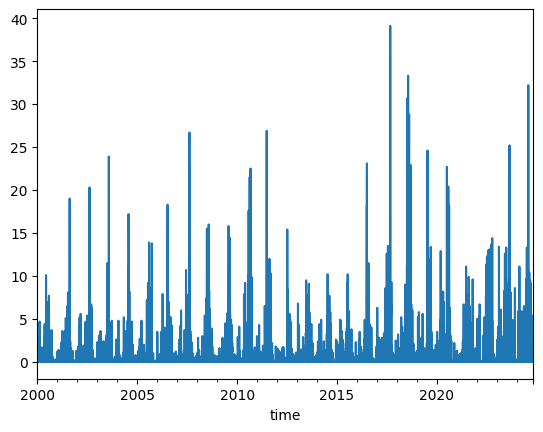

In [9]:
rain = df1['rain']
rain.plot()

## 2.4 For Multivariate: Converting TIme Stamp into usable signals

time stamp (using rain col):
1. day sin & day cos
2. year sin & year cos

In [ ]:
rain_df = pd.DataFrame({'Rain': rain})
rain_df

,Rain
time,
2000-01-01 00:00:00,0.0
2000-01-01 01:00:00,0.0
2000-01-01 02:00:00,0.0
2000-01-01 03:00:00,0.0
2000-01-01 04:00:00,0.0
...,...
2024-10-31 19:00:00,0.0
2024-10-31 20:00:00,0.0
2024-10-31 21:00:00,0.0


In [15]:
rain_df[rain_df['Rain'] != 0]['Rain']

time
2000-01-09 04:00:00    0.1
2000-01-11 02:00:00    0.2
2000-01-11 03:00:00    0.3
2000-01-12 04:00:00    0.2
2000-01-12 05:00:00    0.6
                      ... 
2024-10-14 09:00:00    0.1
2024-10-21 08:00:00    0.1
2024-10-21 09:00:00    0.1
2024-10-26 01:00:00    0.1
2024-10-26 11:00:00    0.1
Name: Rain, Length: 35952, dtype: float64

In [11]:
rain_df['Seconds'] = rain_df.index.map(pd.Timestamp.timestamp)
rain_df

,Rain,Seconds
time,,
2000-01-01 00:00:00,0.0,9.466848e+08
2000-01-01 01:00:00,0.0,9.466884e+08
2000-01-01 02:00:00,0.0,9.466920e+08
2000-01-01 03:00:00,0.0,9.466956e+08
2000-01-01 04:00:00,0.0,9.466992e+08
...,...,...
2024-10-31 19:00:00,0.0,1.730401e+09
2024-10-31 20:00:00,0.0,1.730405e+09
2024-10-31 21:00:00,0.0,1.730408e+09


In [25]:
day = 24 * 60 * 60
year = (365.2425) * day

rain_df['Day sin'] = np.sin(rain_df['Seconds'] * (2 * np.pi / day))
rain_df['Day cos'] = np.cos(rain_df['Seconds'] * (2 * np.pi / day))
rain_df['Year sin'] = np.sin(rain_df['Seconds'] * (2 * np.pi / year))
rain_df['Year cos'] = np.cos(rain_df['Seconds'] * (2 * np.pi / year))
rain_df

,Rain,Seconds,Day sin,Day cos,Year sin,Year cos
time,,,,,,
2000-01-01 00:00:00,0.0,9.466848e+08,-5.461913e-12,1.000000,-0.004731,0.999989
2000-01-01 01:00:00,0.0,9.466884e+08,2.588190e-01,0.965926,-0.004014,0.999992
2000-01-01 02:00:00,0.0,9.466920e+08,5.000000e-01,0.866025,-0.003297,0.999995
2000-01-01 03:00:00,0.0,9.466956e+08,7.071068e-01,0.707107,-0.002580,0.999997
2000-01-01 04:00:00,0.0,9.466992e+08,8.660254e-01,0.500000,-0.001864,0.999998
...,...,...,...,...,...,...
2024-10-31 19:00:00,0.0,1.730401e+09,-9.659258e-01,0.258819,-0.863191,0.504877
2024-10-31 20:00:00,0.0,1.730405e+09,-8.660254e-01,0.500000,-0.862829,0.505496
2024-10-31 21:00:00,0.0,1.730408e+09,-7.071068e-01,0.707107,-0.862466,0.506114


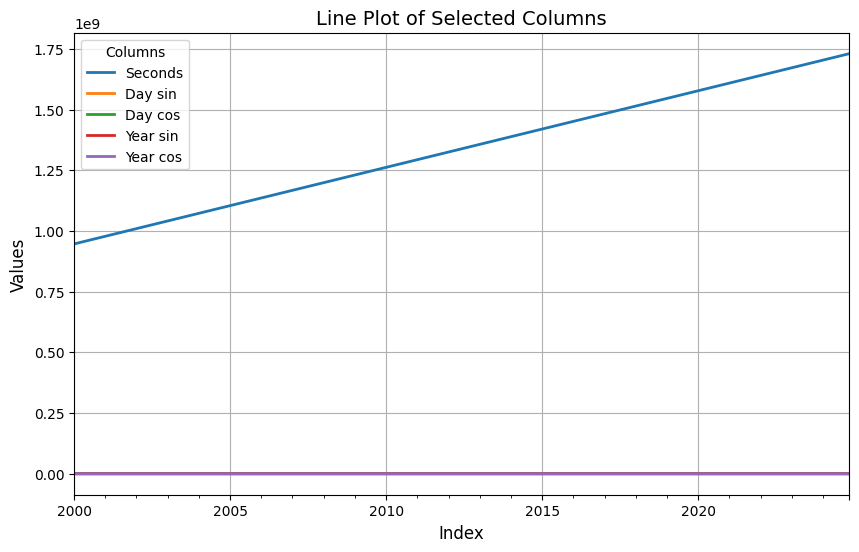

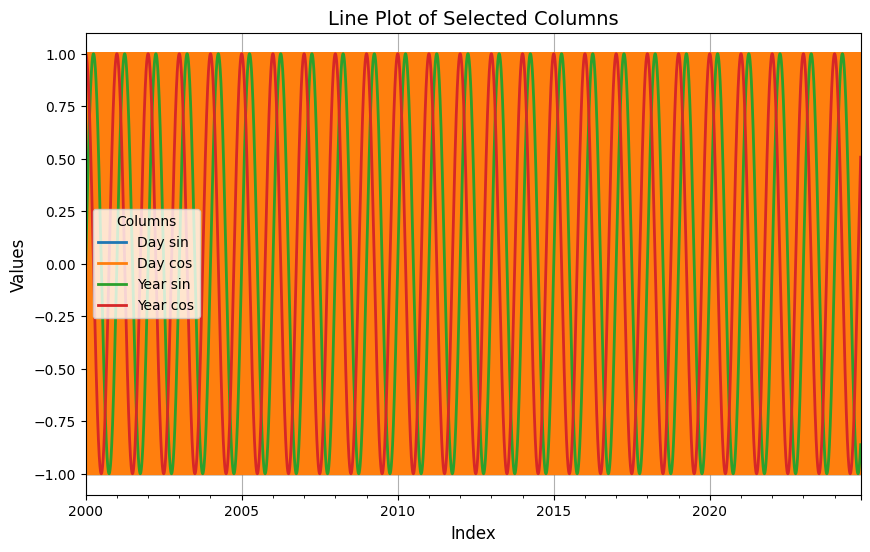

In [23]:
def plot_columns(df, columns_to_plot):
    """
    Plots specified columns of a DataFrame.

    Parameters:
    - df: pandas DataFrame
    - columns_to_plot: List of column names to plot
    """

    # Plot the data
    df[columns_to_plot].plot(
        figsize=(10, 6),
        linewidth=2
    )

    # Customize the plot
    plt.xlabel('Index', fontsize=12)
    plt.ylabel('Values', fontsize=12)
    plt.title(f'Line Plot of Selected Columns', fontsize=14)
    plt.legend(title='Columns', fontsize=10)
    plt.grid(True)
    plt.show()

plot_columns(rain_df, ['Seconds', 'Day sin', 'Day cos', 'Year sin', 'Year cos'])

plot_columns(rain_df, ['Day sin', 'Day cos', 'Year sin', 'Year cos'])

In [26]:
rain_df = rain_df.drop(['Seconds'], axis=1)
rain_df.columns

Index(['Rain', 'Day sin', 'Day cos', 'Year sin', 'Year cos'], dtype='object')

## 2.5 Batch Windowing

In [27]:
# [[[r1, ds1, dc1], [r2, ds2, dc2], [r3, ds3, dc3], [r4, ds4, dc4], [r5, ds5, dc5]]] = [r6]
# [[[r2, ds2], [r3, ds3], [r4, ds4], [r5, ds5], [r6, ds6]]] = [r7]
# [[[r3, ds3], [r4, ds4], [r5, ds5], [r6, ds6], [r7, ds7]]] = [r8]

def df_to_X_y(df, window_size=6):
    df_as_np = df.to_numpy()
    X = []
    y = []
    
    for i in range(len(df_as_np) - window_size):
        row = [r for r in df_as_np[i: i + window_size]]
        X.append(row)
        
        label = df_as_np[i + window_size][0]
        y.append(label)
    
    return np.array(X), np.array(y)

In [28]:
X1, y1 = df_to_X_y(rain_df)
X1.shape, y1.shape

((217698, 6, 5), (217698,))

## 2.6 Train Test Val Split

In [29]:
X_train1, y_train1 = X1[:200000], y1[:200000]
X_val1, y_val1 = X1[200000:209000], y1[200000:209000]
X_test1, y_test1 = X1[209000:], y1[209000:]

X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((200000, 6, 5), (200000,), (9000, 6, 5), (9000,), (8698, 6, 5), (8698,))

## 2.7 Standardization (Standard Normal Distribution)

In [30]:
rain_df.Rain.unique()

array([ 0. ,  0.1,  0.2,  0.3,  0.6,  0.4,  0.7,  0.5,  0.9,  1.1,  0.8,
        1.4,  1.3,  2. ,  2.3,  1. ,  1.2,  1.5,  3. ,  2.7,  1.6,  1.9,
        3.3,  4.7,  3.9,  3.4,  2.5,  2.2,  2.1,  1.7,  1.8,  4.4,  3.1,
        2.4,  4.2,  4.3,  6.5,  7.6,  8.6,  8.9,  7.7,  7.8, 10.1,  9.7,
        9.6,  8.7,  8.3,  7.3,  4.5,  3.5,  3.2,  2.6,  2.8,  6.4,  4.9,
        5.2,  6. ,  3.7,  3.6,  3.8,  2.9,  4.8,  6.7,  5.9,  7. ,  5.1,
        4.6,  5.4,  5.5,  4.1,  6.1,  8.1,  5. , 12.4, 15.9, 17.9, 19. ,
       18.7, 17.4, 14.1,  9.8,  6.9,  5.3,  5.6,  6.3,  9.2, 13.9, 19.3,
       16.7, 18.8, 18.6, 15.4, 10.9,  8.2, 12. , 15.6, 16.9, 20.3,  4. ,
       11.5, 11.4,  9.4,  8. , 15.8, 19.8, 22.8, 23.9, 23.5, 21.1, 12.5,
       10.7,  9. , 11.6, 14.5, 16.5, 17.2, 16.4, 15.2,  9.5,  7.9,  8.4,
        6.6,  7.1, 10.3, 10.8,  7.2, 11.2,  6.2,  6.8,  9.3, 11.9, 13.8,
       13.3, 13.2,  5.7, 15.7, 18.3,  5.8, 21. , 19.9, 21.4, 25.1, 26.7,
       22.9,  8.8,  7.4, 11. , 13.7, 15. , 15.5, 14

In [31]:
rain_training_mean = np.mean(X_train1[:, :, 0])
rain_training_std = np.std(X_train1[:, :, 0])

def preprocess_standardize(X):
    X[:, :, 0] = (X[:, :, 0] - rain_training_mean) / rain_training_std
    return X

In [32]:
preprocess_standardize(X_train1)
preprocess_standardize(X_val1)
preprocess_standardize(X_test1)

array([[[-1.98473682e-01,  8.66025404e-01, -5.00000000e-01,
         -8.38029166e-01,  5.45625436e-01],
        [-1.98473682e-01,  7.07106781e-01, -7.07106781e-01,
         -8.37637856e-01,  5.46225980e-01],
        [-1.98473682e-01,  5.00000000e-01, -8.66025404e-01,
         -8.37246116e-01,  5.46826244e-01],
        [-1.98473682e-01,  2.58819045e-01, -9.65925826e-01,
         -8.36853946e-01,  5.47426227e-01],
        [-1.98473682e-01,  6.44024848e-12, -1.00000000e+00,
         -8.36461345e-01,  5.48025928e-01],
        [-1.98473682e-01, -2.58819045e-01, -9.65925826e-01,
         -8.36068315e-01,  5.48625348e-01]],

       [[-1.98473682e-01,  7.07106781e-01, -7.07106781e-01,
         -8.37637856e-01,  5.46225980e-01],
        [-1.98473682e-01,  5.00000000e-01, -8.66025404e-01,
         -8.37246116e-01,  5.46826244e-01],
        [-1.98473682e-01,  2.58819045e-01, -9.65925826e-01,
         -8.36853946e-01,  5.47426227e-01],
        [-1.98473682e-01,  6.44024848e-12, -1.00000000e+00,
  

## 2.8 Combining 'df1' & 'rain_df'

In [36]:
df2 = pd.concat([df1, rain_df], axis=1)
df2 = df2.drop(['time','rain'], axis=1)
df2

,temperature_2m,relative_humidity_2m,dew_point_2m,cloud_cover_low,cloud_cover_mid,et0_fao_evapotranspiration,vapour_pressure_deficit,wind_speed_10m,wind_speed_100m,wind_gusts_10m,Rain,Day sin,Day cos,Year sin,Year cos
time,,,,,,,,,,,,,,,
2000-01-01 00:00:00,4.0,96,3.3,0,0,0.00,0.04,3.8,3.6,11.5,0.0,-5.461913e-12,1.000000,-0.004731,0.999989
2000-01-01 01:00:00,4.1,95,3.3,0,1,0.00,0.04,4.1,4.4,11.9,0.0,2.588190e-01,0.965926,-0.004014,0.999992
2000-01-01 02:00:00,4.0,95,3.2,0,1,0.01,0.04,3.8,4.5,11.9,0.0,5.000000e-01,0.866025,-0.003297,0.999995
2000-01-01 03:00:00,6.5,92,5.3,0,3,0.02,0.07,4.3,4.0,13.0,0.0,7.071068e-01,0.707107,-0.002580,0.999997
2000-01-01 04:00:00,12.9,75,8.6,0,0,0.13,0.37,2.0,2.5,13.0,0.0,8.660254e-01,0.500000,-0.001864,0.999998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-31 19:00:00,17.1,84,14.4,0,0,0.00,0.31,4.6,7.9,8.6,0.0,-9.659258e-01,0.258819,-0.863191,0.504877
2024-10-31 20:00:00,17.2,80,13.8,0,0,0.00,0.39,3.3,4.6,7.2,0.0,-8.660254e-01,0.500000,-0.862829,0.505496
2024-10-31 21:00:00,17.3,77,13.2,0,0,0.00,0.46,3.1,2.6,5.8,0.0,-7.071068e-01,0.707107,-0.862466,0.506114


In [37]:
df2.columns

Index(['temperature_2m', 'relative_humidity_2m', 'dew_point_2m',
       'cloud_cover_low', 'cloud_cover_mid', 'et0_fao_evapotranspiration',
       'vapour_pressure_deficit', 'wind_speed_10m', 'wind_speed_100m',
       'wind_gusts_10m', 'Rain', 'Day sin', 'Day cos', 'Year sin', 'Year cos'],
      dtype='object')

In [ ]:
remaining_columns_to_target = ['temperature_2m', 'relative_humidity_2m', 'dew_point_2m',
       'cloud_cover_low', 'cloud_cover_mid', 'et0_fao_evapotranspiration',
       'vapour_pressure_deficit', 'wind_speed_10m', 'wind_speed_100m',
       'wind_gusts_10m']

# 3.0 Model

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model